# TP 1: Parcours des protons dans la matière

### Par Mathieu Marquis, Charles-Antoine Parent et Thomas Piuze

In [1]:
import timeit
import numpy as np
import scipy as sp
import graphinglib as gl
import matplotlib.pyplot as plt
import pandas as pd

from scipy.constants import N_A, c, m_e, m_p, e
from scipy.stats import moyal

In [2]:
# Définition de fonctions et classes utiles

def f(T, milieu='os'):
    return 1/pouvoir_collisionnel(T, milieu)

def trapezes(a, b, N, milieu):
    h = (b - a) / N
    R = 0.5 * (f(a, milieu) + f(b, milieu))
    for k in range(1, N):
        R += f(a + k*h, milieu)
    return h*R


## Questions:

### 1- Exprimez la densité électronique $n_e$ d’un milieu en fonction de sa composition atomique et de sa masse volumique $\rho$, et calculer $n_e$ pour l’eau (liquide) et l’os compact (définition de l’ICRU). On s’appuiera sur les données du NIST pour les compositions atomiques de ces matériaux.

La contribution à la densité électronique d'une molécule pour chaque élément $i$ est donnée par
$$n_e^{(i)}=\rho A^{(i)}\frac{N_e^{(i)}N_A}{M^{(i)}}$$
où
$\rho$ : masse volumique de la molécule,
$A^{(i)}$ : abondance massique de l'élément $i$,
$N_e^{(i)}$ : nombre d'électrons par atome de l'élément $i$,
$N_A$ : nombre d'Avogadro,
$M^{(i)}$ : masse molaire de l'élément $i$.

Ainsi, la densité électronique d'une molécule avec $N$ éléments distincts correspond à
$$n_e=\rho N_A\sum_{i=1}^N\frac{A^{(i)}N_e^{(i)}}{M^{(i)}}$$


La cellule suivante donne les numéros atomiques, la fraction massique et la masse molaire des éléments composant l'eau et l'os compact, de même que la masse volumique de ces deux substances. Elle fait ensuite appel à la fonction `densite_electronique` pour obtenir la densité électronique de l'eau et de l'os compact. La fonction `densite_electronique` reçoit en argument la composition chimique d'une matière et sa masse volumique en g/cm $^3$ et retourne sa densité électronique en électrons par cm $^3$.

In [3]:
def densite_electronique(composition: np.ndarray, rho: float) -> float:
    """
    Retourne la densité électronique en électrons par centimètre cube.

    Paramètres
    ----------
    composition : np.array
        Array où chaque ligne représente le numéro atomique, la composition atomique du milieu
        (en fraction de 1) et la masse molaire de chaque élément composant le milieu.
    rho : float
        Densité du milieu en grammes par mole.
    """
    assert composition[:,1].sum() == 1, "l'abondance chimique de tous les éléments devrait être sommée à 1."
    return rho * N_A * np.sum(composition[:,1] * composition[:,0] / composition[:,2], axis=0)

# Numéros atomiques, composition atomique et masse molaire
composition_eau = np.array([
    [1, 0.111894, 1.008],
    [8, 0.888106, 15.999]
])
composition_os = np.array([
    [1, 0.063984, 1.008], 
    [6, 0.278000, 12.011], 
    [7, 0.027000, 14.007], 
    [8, 0.410016, 15.999],
    [12, 0.002000, 24.305], 
    [15, 0.070000, 30.974], 
    [16, 0.002000, 32.06], 
    [20, 0.147000, 40.078]
])

# Masses volumiques en g/cm^3
rho_eau = 1.00000
rho_os = 1.85000

# Densités électroniques en électrons/cm^3
n_eau = densite_electronique(composition_eau, rho_eau)
n_os = densite_electronique(composition_os, rho_os)
print("Densité électronique de l'eau :", n_eau)
print("Densité électronique le l'os compact :", n_os)

Densité électronique de l'eau : 3.342810286137214e+23
Densité électronique le l'os compact : 5.9058775990097234e+23


### 2- Tracez les courbes du pouvoir d’arrêt collisionnel massique pour ces milieux en fonction de l’énergie cinétique ($T$). Pour expliciter la dépendance en $T$ de $S_{col}$, utilisez les relations 9 et 10 ci-bas. Pour le graphique, utilisez une échelle logarithmique en abscisse. Vous trouverez les énergies moyennes d’excitation $I$ de ces matériaux sur le site du NIST également.

La cellule suivante définit d'abord quelques constantes importantes, de même que les énergies moyennes d'excitation de l'eau liquide et de l'os compact. Elle fait ensuite appel à la fonction `pouvoir_collisionnel` pour tracer les courbes du pouvoir d'arrêt collisionnel massique. La fonction `pouvoir_collisionnel` reçoit en argument l'énergie cinétique du proton (MeV), la densité électronique du milieu (électrons/cm $^3$), l'énergie moyenne d'excitation du milieu (MeV) et la masse volumique du milieu (g/cm $^3$). Elle retourne le pouvoir d'arrêt collisionnel massique si `massique is True`, et le pouvoir d'arrêt collisionnel standard sinon.

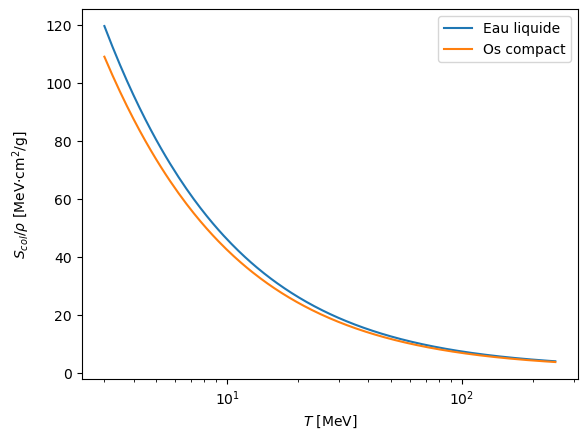

In [4]:
# Constantes importantes
mp = m_p/(10**6*e) # En MeV/c^2
me = m_e/(10**6*e) # En MeV/c^2
r_e = 10**2*sp.constants.value('classical electron radius') # En cm

# Énergies d'excitation en MeV
I_eau = 75.000000e-6
I_os = 91.900000e-6

def pouvoir_collisionnel(T: np.ndarray, milieu: str, massique: bool=False) -> np.ndarray:
    """
    Retourne le pouvoir collisionnel en fonction de l'énergie cinétique pour un milieu.

    Paramètres
    ----------
    T : np.array
        Énergie cinétique en MeV.
    milieu : str, = 'eau' | 'os'
        Milieu dans lequel faire le calcul.
    massique : bool, default=False
        Retourne le pouvoir collisionnel massique si True.
    """
    if milieu == 'eau':
        n_e, I, rho = n_eau, I_eau, rho_eau
    elif milieu == 'os':
        n_e, I, rho = n_os, I_os, rho_os
    else:
        raise ValueError("milieu doit être 'eau' or 'os'")
    gamma = T / (mp * c**2) + 1
    beta = ((gamma**2 - 1) / gamma**2)**0.5
    a = 2 * me * c**2
    b = 1 + (me/mp)**2
    delta = 2*me/mp
    Tmax = a * (gamma**2 - 1) / (b + delta*gamma)
    U = np.pi * r_e**2 * a * n_e
    k = a**2/I**2
    S = (U / beta**2) * (np.log(k * beta**2 * gamma**2 * Tmax/a) - 2 * beta**2)
    if massique:
        S /= rho
    return S

# Graphique
Tgraph = np.linspace(3, 250, 1000) # En MeV
plt.plot(Tgraph, pouvoir_collisionnel(Tgraph, 'eau', massique=True), label='Eau liquide')
plt.plot(Tgraph, pouvoir_collisionnel(Tgraph, 'os', massique=True), label='Os compact')
plt.xlabel('$T$ [MeV]')
plt.ylabel(r'$S_{col}/\rho$ [MeV$\cdot$cm$^2$/g]', rotation=90, labelpad=10)
plt.xscale('log')
plt.legend()
plt.show()

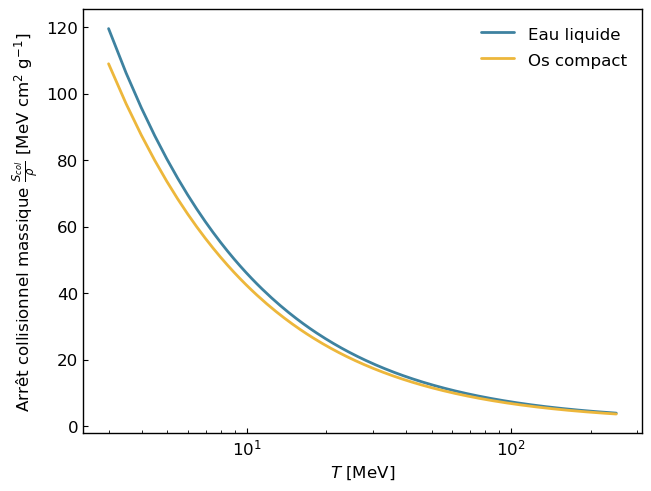

In [5]:
# GraphingLib version !

r_e = 10**2*sp.constants.value("classical electron radius") # En cm
_m_e = sp.constants.value("electron mass energy equivalent in MeV") / c**2
_m_p = sp.constants.value("proton mass energy equivalent in MeV") / c**2
I_eau = 75.000000e-6
I_os = 91.900000e-6

def get_S_col(T: float | np.ndarray, n_e: float, I: float, rho: float) -> float | np.ndarray:
    gamma = T / (_m_p*c**2) + 1
    beta = np.sqrt((gamma**2 - 1) / gamma**2)
    T_e_max = (2*_m_e*c**2 * (gamma**2 - 1)) / (1+(_m_e/_m_p)**2 + 2*_m_e/_m_p * gamma)
    S_col = 2*np.pi*r_e**2*_m_e*c**2*n_e / beta**2 * (np.log(2*_m_e*(c*beta*gamma)**2*T_e_max / I**2) - 2*beta**2)
    return S_col / rho

fig = gl.Figure(
    log_scale_x=True,
    x_label="$T$ [MeV]",
    y_label=r"Arrêt collisionnel massique $\frac{S_{col}}{\rho}$ [MeV cm$^2$ g$^{-1}$]"
)
fig.add_elements(gl.Curve.from_function(lambda T: get_S_col(T, n_eau, I_eau, rho_eau), 3, 250, label="Eau liquide"))
fig.add_elements(gl.Curve.from_function(lambda T: get_S_col(T, n_os, I_os, rho_os), 3, 250, label="Os compact"))
fig.show()


## Portée des protons dans la matière

L’approximation d’une décélération continue (*Continuous Slowing Down Approximation*, CSDA)
des protons dans la matière, en ligne droite, permet d’estimer leur portée dans le milieu
considéré (la distance qu’ils peuvent parcourir avant d’avoir transféré au milieu la totalité
de leur énergie cinétique initiale). Ici, seuls les transferts d’énergie vers les électrons du milieu
sont considérés.

### 3- En quoi la seule considération des interactions des protons avec les électrons du milieu est-elle justifiée ? Appuyez votre réponse en comparant les contributions des interactions nucléaires (protons avec noyaux atomiques du milieu) et radiatives (pertes d’énergie par *Bremsstrahlung*) au pouvoir d’arrêt total sur la plage 3-250 MeV. Les données PSTAR et un graphique pourraient être utiles.

La portée par CSDA ($R_{CSDA}$) est obtenue en intégrant l’inverse du pouvoir d’arrêt total par
rapport à l’énergie :

$$R_{CSDA} = \int_0^{T_i}\frac{dT'}{S_{col}},$$

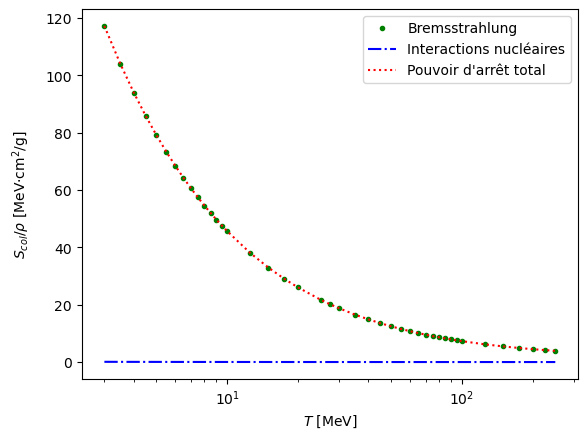

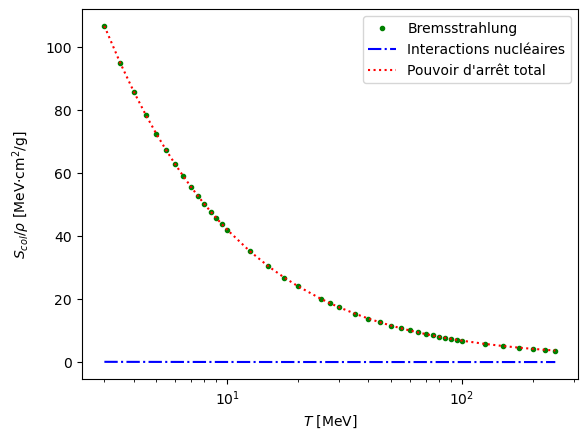

In [6]:
eau, os = 'pstar_eau.csv', 'pstar_os.csv'

def portee(file):
    donnees = pd.read_csv(file, sep=' ', index_col=False)
    energy, bremss, nuclear, total = np.array(donnees['Kinetic']), np.array(donnees['Electron']), np.array(donnees['Nuclear']), np.array(donnees['Total'])
    plt.plot(energy, bremss, 'g.', label = 'Bremsstrahlung')
    plt.plot(energy, nuclear, 'b-.', label = 'Interactions nucléaires')
    plt.plot(energy, total, 'r:', label = "Pouvoir d'arrêt total")
    plt.xlabel('$T$ [MeV]')
    plt.ylabel(r'$S_{col}/\rho$ [MeV$\cdot$cm$^2$/g]', rotation=90, labelpad=10)
    plt.xscale('log')
    plt.legend()

    plt.show()
    
portee(eau)
portee(os)

### 4-  Pourquoi intègre-t-on l’inverse du pouvoir d’arrêt pour déterminer la portée ?

Le pouvoir d'arrêt collisionnel est défini comme:

$$ S_{col} = -\left(\frac{dT}{dx}\right)_{col} $$

Soit l'opposé de la variation d'énergie cinétique par unité de longueur. Ainsi:

$$ R_{CSDA} = \int_0^{T_i}\frac{dT'}{S_{col}} = \int_0^{T_i}\frac{dT'}{-(dT'/dx)_{col}} = -\int_{x(0)}^{x(T_i)}dx = \int_{x(T_i)}^{x(0)}dx $$

Ce qui correspond effectivement à la portée de la particule. L'intégration de l'inverse du pouvoir d'arrêt est donc due à la définition de ce dernier.

### 5- Justifiez la nécessité d’employer une méthode numérique pour calculer la portée des protons.

### 6- Implémenter deux algorithmes d’intégration numérique pour calculer la portée des protons dans l’eau et dans l’os compact ; le premier avec la méthode des trapèzes et le second avec la méthode de Romberg. Considérez des protons d’énergie initiale de 150 MeV à l’entrée du milieu. Estimez le nombre de tranches requises pour atteindre la précision machine avec chaque méthode, et discutez des conséquences sur le temps de calcul. Notez que comme l’expression 4 n’est valide que pour des protons ayant une énergie supérieure à 3 MeV, cette valeur sera utilisée comme borne d’intégration au lieu de 0. Le biais introduit dans les résultats par cette approximation ne vous sera pas reproché.

In [ ]:
# Méthode des trapèzes
trapezes(3, 150, 100, 'eau')
trapezes(3, 150, 100, 'os')

# Recherche de la valeur de N permettant d'atteindre la précision machine
# Utilisation du nesting et des résultats calculés à l'itération précédente
def trapezes_N(a: float, b:float, milieu: str, N0: int=10, erreur_max: float=1e-16, erreur_machine=False):
    """Méthodes des trapèzes avec nesting"""
    # Initialisation
    n = N0
    approx = 1
    if erreur_machine:
        erreur_max = 0

    I_n = trapezes(a, b, n, milieu)
    while approx > erreur_max:
        # Nesting pour calculer I_2n
        s = 0
        h = (b-a)/(2*n)
        for k in range(1, 2*n, 2):
            s += f(a+k*h, milieu)
        I_2n = 0.5*I_n+h*s
        # Erreurs d'approximation et de représentation
        approx = (I_2n-I_n)/3
        if erreur_machine:
            erreur_max = 10**(-16)*I_2n
        #print(n, I_2n, approx, erreur_max)
        # Préparation pour l'itération suivante
        n *= 2
        I_n = I_2n
    return I_n, approx, n

#trapezes_N(3, 150, 'eau')

In [ ]:
# Romberg
def romberg(a: float, b: float, milieu:str, N0: int=10, erreur_max: float=1e-16, erreur_machine=False):
    """"""
    # Initialisation des différents paramètres
    n = N0
    erreur = 1
    if erreur_machine:
        erreur_max = 0

    # Initialisation de la liste de listes contenant les résultats
    R_11 = trapezes(a, b, n, milieu)
    R = [[R_11]]

    i = 2
    while erreur > erreur_max:
        R_i = []
        # Nesting pour calculer R_2n
        h = (b - a) / (2*n)
        s = 0
        for k in range(1, 2*n, 2):
            s += f(a + k*h, milieu)
        R_i.append(0.5*R[-1][0] + h*s)

        # Calcul de R gratuits
        for m in range(2, i+1):
            erreur = 1/(4**m - 1) * (R_i[-1] - R[-1][m - 2]) # Erreur d'approximation de R_i[-1]
            R_nouveau = R_i[-1] + erreur
            R_i.append(R_nouveau)

        # Erreur machine
        if erreur_machine:
            erreur_max = 1e-16 * R_i[-2] # Erreur machine de l'ancien R_i[-1], maintenant R_i[-2]

        # Préparation pour l'itération suivante
        R.append(R_i)
        i += 1
        n *= 2
    return (R[-1][-2], erreur, n)

romberg(3, 150, 'eau', erreur_machine=True)

### 7- Tracez un graphique de la portée calculée par chaque méthode en fonction du nombre d’échantillons (de tranches) considéré. Le même graphique rapportera l’estimation pratique de l’erreur d’approximation pour les deux méthodes (avec une échelle différente en ordonnée). Votre graphique comprendra des points choisis de façon à bien représenter le comportement de vos algorithmes (des échelles logarithmiques pourraient être nécessaires). Doubler le nombre de tranches entre chaque évaluation pourrait s’avérer judicieux.


## Estimation analytique de l'erreur

### Pour la méthode des trapèzes, obtenez la valeur de l’erreur sur la portée calculée à l’ordre le plus grand. À cette fin, il faut connaître la dérivée première de la fonction à intégrer (qui est l’inverse du pouvoir d’arrêt).


### 8- Établir l’expression analytique de la dérivée du pouvoir d’arrêt en fonction de $T$. Cette première étape vous permettra de calculer la dérivée de l’inverse du pouvoir d’arrêt plus facilement ensuite. Pour vous aider, vous pouvez exprimer le pouvoir d’arrêt en fonction de $\gamma$ et utiliser le théorème de dérivation des fonctions composées. Utilisez aussi les définitions suivantes pour simplifier la notation :

$$
\begin{align*}
T_e^{max} = \frac{a(\gamma^2-1)}{b+\delta\gamma}, \quad \text{avec} \quad a = 2m_ec^2, \quad b = 1+(\frac{m_e}{m_p})^2 \quad \text{et} \quad \delta = 2\frac{m_e}{m_p}
\end{align*}
$$

### et

$$
\begin{align*}
U &= 2\pi r_e^2m_ec^2n_e \\
k &= \frac{a^2}{I^2}
\end{align*}
$$

### sachant aussi que

$$
\begin{align*}
T = (\gamma-1)m_pc^2 \rightarrow \gamma = \frac{T}{m_pc^2}+1 \\
\gamma = \frac{1}{\sqrt{1-\beta^2}} \rightarrow \gamma^2\beta^2 = \gamma^2-1
\end{align*}
$$

La dérivée du pouvoir d'arrêt par rapport à $T$ se calcule comme suit: 

$$ \frac{dS_{col}}{dT} = \frac{dS_{col}}{d\gamma}\frac{d\gamma}{dT} $$

Exprimons d'abord $S_{col}$ en fonction de $\gamma$ uniquement:

$$ 
\begin{align*}
    S_{col} &= 2\pi r_e^2m_ec^2n_e\frac{1}{\beta^2}\left[\ln\left(\frac{2m_ec^2\beta^2\gamma^2T_e^{max}}{I^2}\right)-2\beta^2\right] \\ 
    &= \frac{U}{\beta^2}\left[\ln\left(\frac{a\beta^2\gamma^2\cdot(\gamma^2-1)}{I^2(b+\delta\gamma)}\right)-2\beta^2\right] \\ 
    &= \frac{U\gamma^2}{\gamma^2-1}\ln\left(\frac{k(\gamma^2-1)^2}{b+\delta\gamma}\right)-2U
\end{align*}
$$

On dérive ensuite $S_{col}$ par rapport à $\gamma$:

$$ 
\begin{align*}
    \frac{dS_{col}}{d\gamma} &= \left[\frac{2U\gamma}{\gamma^2-1}-\frac{2U\gamma^3}{(\gamma^2-1)^2}\right]\ln\left(\frac{k(\gamma^2-1)^2}{b+\delta\gamma}\right)+\frac{U\gamma^2}{\gamma^2-1}\left[\frac{b+\delta\gamma}{k(\gamma^2-1)^2}\left(\frac{4k\gamma(\gamma^2-1)}{b+\delta\gamma}-\frac{k\delta(\gamma^2-1)^2}{(b+\delta\gamma)^2}\right)\right] \\
    &= -\frac{2U\gamma}{(\gamma^2-1)^2}\ln\left(\frac{k(\gamma^2-1)^2}{b+\delta\gamma}\right)+\frac{U\gamma^2}{(\gamma^2-1)^2}\left[4\gamma-\frac{\delta(\gamma^2-1)}{b+\delta\gamma}\right] \\
    &= \frac{U\gamma}{(\gamma^2-1)^2}\left[4\gamma^2-\frac{\delta\gamma(\gamma^2-1)}{b+\delta\gamma}-2\ln\left(\frac{k(\gamma^2-1)^2}{b+\delta\gamma}\right)\right] 
\end{align*}
$$

Pour $\frac{d\gamma}{dT}$, nous avons:

$$ \gamma = \frac{T}{m_pc^2}+1 \longrightarrow \frac{d\gamma}{dT} = \frac{1}{m_pc^2} $$

Donc:

$$ 
\begin{align*}
    \frac{dS_{col}}{dT} &= \frac{dS_{col}}{d\gamma}\frac{d\gamma}{dT} \\
    &= \frac{U\gamma}{m_pc^2(\gamma^2-1)^2}\left[4\gamma^2-\frac{\delta\gamma(\gamma^2-1)}{b+\delta\gamma}-2\ln\left(\frac{k(\gamma^2-1)^2}{b+\delta\gamma}\right)\right] \\
    \text{où} \quad \gamma &= \gamma(T) = \frac{T}{m_pc^2}+1 
\end{align*}
$$

### 9- Rapportez vos portées calculées dans un tableau, qui comprendra aussi les erreurs d’approximation calculées (pour la méthode des trapèzes) et évaluées de façon pratique (pour la méthode des trapèzes et de Romberg). Il s’agit essentiellement des résultats déjà obtenus (auxquels on ajoute les erreurs calculées pour la méthode des trapèzes). Commentez vos résultats.


Si on néglige les termes en $\mathcal{O}(h^4)$ et plus, l'erreur d'approximation $\epsilon$ de la méthode des trapèzes est:

$$ \epsilon = \frac{1}{12}h^2[f'(a)-f'(b)] $$

Et puisque la fonction à intégrer est $f(T) = \frac{1}{S_{col}(T)}$, $f'(T)$ devient:

$$ f'(T) = \frac{-1}{S_{col}^2(T)}\frac{dS_{col}}{dT} $$

In [ ]:
def derivee(T, milieu):
    # Propriétés du milieu
    if milieu == 'eau':
        n_e, I, rho = n_eau, I_eau, rho_eau
    if milieu == 'os':
        n_e, I, rho = n_os, I_os, rho_os
    # Calcul des variables et constantes
    gamma = T/(mp*c**2)+1
    a = 2*me*c**2
    b = 1+(me/mp)**2
    delta = 2*me/mp
    U = np.pi*r_e**2*a*n_e
    k = a**2/I**2
    # 4 facteurs/termes pour la dérivée
    d1 = U*gamma/(mp*c**2*(gamma**2-1)**2)
    d2 = 4*gamma**2
    d3 = delta*gamma*(gamma**2-1)/(b+delta*gamma)
    d4 = 2*np.log(k*(gamma**2-1)**2/(b+delta*gamma))
    return d1*(d2-d3-d4)

def erreur_trapezes(a, b, N, milieu):
    h = (b-a)/N
    f_prime_a = -f(a, milieu)**2*derivee(a, milieu)
    f_prime_b = -f(b, milieu)**2*derivee(b, milieu)
    return h**2/12*(f_prime_a-f_prime_b)

erreur_trapezes(3, 150, 10, 'eau')

## Optimisation

### Supposons maintenant que l’on cherche à réduire au maximum le temps de calcul, disons pour évaluer en temps quasi-réel la portée de chaque proton individuel émanant de l’accélérateur et dont on connaîtrait précisément l’énergie. Ces protons ont une distribution en énergie pouvant être approximée par une distribution de Moyal, que vous pourrez générer avec `scipy.stats.moyal` avec les paramètres `loc=150, scale=4` (unités en MeV).

### 10- . Utilisez ``moyal.rvs`` pour générer aléatoirement 10 000 énergies tirées de cette distribution et tracez-la (sous forme d’histogramme).

In [ ]:
energy = moyal(loc=150, scale=4)
distribution = energy.rvs(size=10000)

fig = gl.Figure('Énergie [MeV]', 'Compte [-]')
fig.add_elements(gl.Histogram(distribution, number_of_bins=40, show_params=False, label=''))
fig.show()

### 11- À l’aide du module ``timeit``, estimez le nombre de protons que vous pouvez calculer par seconde selon trois méthodes : vos implémentations des méthodes par trapèzes et Romberg ainsi que la fonction ``scipy.integrate.quad``. Utilisez les 10 000 valeurs d’énergie générées plus haut pour faire vos tests. Afin de comparer des pommes avec des pommes, vos calculs doivent tous atteindre la précision par défaut de la routine ``scipy.integrate.quad``.

In [ ]:
erreur_scipy = []
test = "for proton in distribution: erreur_scipy.append(sp.integrate.quad(f, 3, proton)[1])"

time = timeit.timeit(test, globals=globals(), number=1)
print('scipy.integrade.quad :', len(distribution)/time, 'protons/s')

In [ ]:
test = "for i, proton in enumerate(distribution): romberg(3, proton, 'os', erreur_max=erreur_scipy[i])"

time = timeit.timeit(test, globals=globals(), number=1)
print('Méthode de Romberg :', len(distribution)/time, 'protons/s')

In [ ]:
test = "for i, proton in enumerate(distribution[:100]): trapezes_N(3, proton, 'os', erreur_max=erreur_scipy[i])"

time = timeit.timeit(test, globals=globals(), number=1)
print('Méthode des trapèzes :', len(distribution[:100])/time, 'protons/s')

### 12- Faites aussi un histogramme des portées obtenues pour ces 10 000 protons et commentez la distribution obtenue (peut-être en faisant référence au théorème central limite ?)

## Énergie déposée

### Il est possible de calculer l’énergie déposée pour un pas de déplacement du proton $s$ dans un milieu comme suit :

$$
\begin{align*}
s = \int_{T_f}^{T_i}\frac{dT'}{S_{col}}
\end{align*}
$$

### où $T_i$ et $T_f$ sont les énergies cinétiques respectivement avant et après que le proton ait subi une perte d’énergie dans l’épaisseur $s$ du matériau.

### 13- Écrivez un algorithme capable de réaliser le transport des protons subissant une décélération continue dans le milieu et tracez le dépôt d’énergie en fonction de la profondeur pour l’eau et l’os pour des proton d’énergie cinétique 150 MeV (faisceau monoénergétique). Votre courbe comportera un point où l’énergie déposée est nulle. La position de ce point est-elle conforme à vos résultats antérieurs sur la portée ? Qu’est-ce qui influence sa valeur ?


### 14- On nomme cette courbe le pic de Bragg. En déduire l’intérêt des protons pour la radiothérapie.

### 15- Selon vous, est-il nécessaire de calculer les portées jusqu’à la précision machine en protonthérapie ? Pourquoi ?


### 16- En quoi les protons sont-ils préférables aux photons pour traiter un mélanome oculaire ?

### 17- Dans l’approche développée ici, les protons vont essentiellement en ligne droite dans la matière. Est-ce réaliste ? Que devra-t-on éventuellement ajouter à notre modèle ?
